# Data Preparation: Outlier

In [381]:
# Import
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import sklearn.linear_model as skl_lm
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split


In [382]:
# Import the dataset
df = pd.read_csv('data/Default.csv')

In [383]:
df.set_index('Unnamed: 0', inplace=True)
df['default2'] = df.default.factorize()[0]
df['student2'] = df.student.factorize()[0]

In [384]:
x = df.balance.values.reshape(-1,1) # scikit-learn expects a 2D array not a pd.Series :(
y = df.default2
x

array([[ 729.52649521],
       [ 817.18040656],
       [1073.54916401],
       ...,
       [ 845.41198922],
       [1569.00905338],
       [ 200.92218263]])

In [385]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=40)


In [386]:
X_train_w_intercept = sm.add_constant(pd.DataFrame(X_train))
est = sm.Logit(y_train.to_numpy(), X_train_w_intercept).fit()
est.summary2().tables[1]



Optimization terminated successfully.
         Current function value: 0.081182
         Iterations 10


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,-10.570829,0.399128,-26.484813,1.450155e-154,-11.353105,-9.788552
0,0.005482,0.000245,22.375180,6.868051e-111,0.005002,0.005962


In [387]:
X_test_w_intercept = sm.add_constant(pd.DataFrame(X_test))
y_prob = est.predict(X_test_w_intercept)
y_pred = (y_prob > 0.5).astype(int)

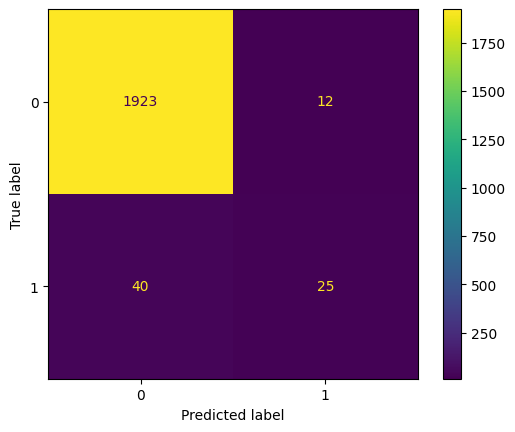

In [388]:
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()
plt.show()

In [389]:
accuracy = metrics.accuracy_score(y_test, y_pred)
accuracy

0.974

In [390]:
# Create 10 new syntetic columns with random values
for i in range(5):
    df[f'random_{i}'] = np.random.rand(df.shape[0])

# Create 5 new columns correlated with balance with some noise
for i in range(5):
    df[f'correlated_{i}'] = df.balance + np.random.normal(0, 100, df.shape[0])



In [391]:
# Select all the columns that are not 'default' or 'student'
X = df.loc[:, ~df.columns.isin(['default', 'student', 'default2', 'student2'])]
y = df.default2


In [392]:
# Divide the dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [393]:
# Fit the model
X_train_w_intercept = sm.add_constant(X_train)
est = sm.Logit(y_train, X_train_w_intercept).fit()
est.summary2().tables[1]

Optimization terminated successfully.
         Current function value: 0.075640
         Iterations 10


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,-12.237944,0.595702,-20.543742,8.755006e-94,-13.405498,-11.070390
balance,0.006286,0.001807,3.478648,5.039498e-04,0.002744,0.009828
income,0.000021,0.000006,3.775839,1.594700e-04,0.000010,0.000033
random_0,0.247667,0.265160,0.934028,3.502897e-01,-0.272038,0.767372
random_1,0.270688,0.270698,0.999962,3.173287e-01,-0.259871,0.801247
random_2,0.005983,0.273427,0.021883,9.825415e-01,-0.529923,0.541890
random_3,-0.175438,0.272641,-0.643476,5.199155e-01,-0.709803,0.358928
random_4,0.271157,0.276608,0.980294,3.269410e-01,-0.270984,0.813299
correlated_0,0.000852,0.000786,1.083316,2.786683e-01,-0.000689,0.002393
correlated_1,0.001076,0.000797,1.349836,1.770685e-01,-0.000486,0.002637


In [394]:
X_test_w_intercept = sm.add_constant(X_test)
y_prob = est.predict(X_test_w_intercept)
y_pred = (y_prob > 0.5).astype(int)


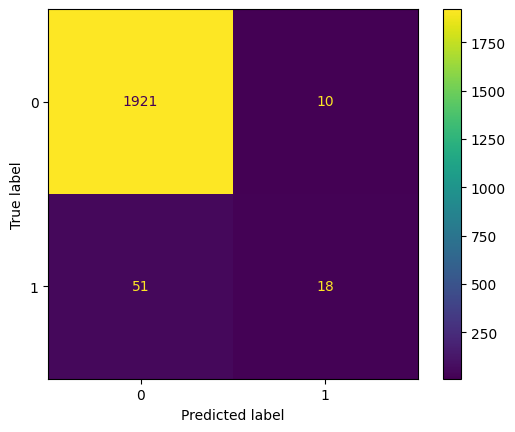

In [395]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

In [396]:
# Accuracy
new_accuracy = metrics.accuracy_score(y_test, y_pred)
new_accuracy



0.9695

In [397]:
if new_accuracy > accuracy:
    print('The accuracy has improved')
elif new_accuracy == accuracy:
    print('The accuracy is the same')
else:
    print('The accuracy is worse')

The accuracy is worse


# Feature Selection
Feature selection is primarily focused on removing non-informative or redundant predictors from the model.



In [398]:
# Import 